In [66]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, Flatten
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix
from keras import Sequential

In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 100     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/patrycja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/patrycja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

In [6]:
train_df_preprocessed

,spans,text,toxicity,toxic_words,sentences,toxicity_sentence
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot. its not any m...,1,"[moron, bigot]","[because hes a moron and a bigot., its not any...","[1.0, 0.0]"
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1,[idiots],[how about we stop protecting idiots and let n...,"[1.0, 0.0]"
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott th...",1,[idiots],"[if people were smart, they would boycott t...",[1.0]
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1,[stupid],[trump claimed that russia will never invade t...,[1.0]
4,[],as long as your willing to pay a lot more for ...,0,[],[as long as your willing to pay a lot more for...,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...
685,"[129, 130, 131, 132, 133, 134]",but ... trumps not bluffing. hes prepared to g...,1,[stupid],"[but ... trumps not bluffing., hes prepared to...","[0.0, 0.0, 0.0, 1.0, 0.0]"
686,"[126, 127, 128, 129, 130, 131]",cant believe the limited knowledge of this art...,1,[stupid],[cant believe the limited knowledge of this ar...,"[0.0, 1.0]"
687,"[24, 25, 26, 27, 28, 29]",i think it conservative idiots who cannot reac...,1,[idiots],[i think it conservative idiots who cannot rea...,[1.0]
688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",youre an id*ot...go away.,1,[youre an idot],[youre an id*ot...go away.],[0.0]


In [157]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])

tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', split=" ",
                      lower=True)
tokenizer.fit_on_texts(train_df.sentence.sum())
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts
###

In [158]:
train_df

,sentence,toxicity_sentence
0,because hes a moron and a bigot.,1.0
1,its not any more complicated than that.,0.0
2,how about we stop protecting idiots and let na...,1.0
3,we can always submit their names for the darwi...,0.0
4,"if people were smart, they would boycott th...",1.0
...,...,...
1987,youre an id*ot...go away.,0.0
1988,unless there is wording in the employment cont...,1.0
1989,or for driving the wrong color car.,0.0
1990,or because our boss is having a really bad day.,0.0


In [159]:
tokenizer[1]

TypeError: 'Tokenizer' object is not subscriptable

In [9]:
import gensim

In [10]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [21]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [160]:
word_index.items()

dict_items([('e', 1), ('t', 2), ('a', 3), ('o', 4), ('i', 5), ('s', 6), ('n', 7), ('r', 8), ('h', 9), ('l', 10), ('d', 11), ('u', 12), ('c', 13), ('y', 14), ('m', 15), ('p', 16), ('g', 17), ('w', 18), ('f', 19), ('b', 20), ('v', 21), ('k', 22), ('j', 23), ('x', 24), ('z', 25), ('0', 26), ('1', 27), ('q', 28), ('5', 29), ('2', 30), ('3', 31), ('9', 32), ('6', 33), ('’', 34), ('7', 35), ('8', 36), ('4', 37), ('“', 38), ('”', 39), ('—', 40), ('™', 41), ('‘', 42), ('é', 43)])

In [23]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        absent_words+=1

In [155]:
data_temp = np.zeros((len(train_df), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(train_df.sentence):
    for k, word in enumerate(sentence):
        print (word)
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_temp[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

b
e
c
a
u
s
e
 
h
e
s
 
a
 
m
o
r
o
n
 
a
n
d
 
a
 
b
i
g
o
t
.
i
t
s
 
n
o
t
 
a
n
y
 
m
o
r
e
 
c
o
m
p
l
i
c
a
t
e
d
 
t
h
a
n
 
t
h
a
t
.
h
o
w
 
a
b
o
u
t
 
w
e
 
s
t
o
p
 
p
r
o
t
e
c
t
i
n
g
 
i
d
i
o
t
s
 
a
n
d
 
l
e
t
 
n
a
t
u
r
e
 
a
d
d
 
s
o
m
e
 
b
l
e
a
c
h
 
t
o
 
t
h
e
 
g
e
n
e
 
p
o
o
l
.
w
e
 
c
a
n
 
a
l
w
a
y
s
 
s
u
b
m
i
t
 
t
h
e
i
r
 
n
a
m
e
s
 
f
o
r
 
t
h
e
 
d
a
r
w
i
n
 
a
w
a
r
d
s
.
i
f
 
p
e
o
p
l
e
 
 
w
e
r
e
 
 
s
m
a
r
t
,
 
t
h
e
y
 
w
o
u
l
d
 
 
b
o
y
c
o
t
t
 
t
h
i
s
 
 
i
n
e
p
t
 
 
a
i
r
l
i
n
e
,
 
 
b
u
t
 
 
 
t
h
e
y
 
 
a
r
e
 
 
n
o
t
 
 
s
m
a
r
t
,
 
 
s
o
 
 
 
r
o
g
u
e
 
 
b
u
s
i
n
e
s
s
e
s
 
 
l
i
k
e
 
 
t
h
i
s
 
 
o
n
e
,
 
 
 
s
t
i
l
l
 
t
h
r
i
v
e
 
 
 
t
a
k
i
n
g
 
t
h
e
 
i
d
i
o
t
s
 
 
f
o
r
 
 
a
 
r
i
d
e
.
.
.
t
r
u
m
p
 
c
l
a
i
m
e
d
 
t
h
a
t
 
r
u
s
s
i
a
 
w
i
l
l
 
n
e
v
e
r
 
i
n
v
a
d
e
 
t
h
e
 
u
k
r
a
i
n
e
,
 
w
h
e
n
 
r
u
s
s
i
a
 
a
l
r
e
a
d
y
 
h
a
s
 
-
 
h
o
w
 
s
t
u
p
i
d
 
c
a
n
 
p
e
o
p


s
 
i
t
 
a
n
 
i
s
s
u
e
 
n
o
w
?
a
n
d
 
t
h
e
r
e
 
w
a
s
n
t
 
a
n
y
t
h
i
n
g
 
i
l
l
e
g
a
l
 
a
b
o
u
t
 
i
t
,
 
s
o
 
i
t
s
 
n
o
t
 
a
 
c
r
i
m
e
.
o
h
,
 
a
n
d
 
t
h
e
 
s
a
n
d
e
r
s
 
c
a
m
p
a
i
g
n
 
s
i
g
n
e
d
 
t
h
e
 
s
a
m
e
 
a
g
r
e
e
m
e
n
t
 
w
i
t
h
 
t
h
e
 
d
n
c
 
i
n
 
o
c
t
 
2
0
1
5
.
 
s
o
m
e
h
o
w
 
t
h
a
t
s
 
o
v
e
r
l
o
o
k
e
d
.
t
h
o
u
g
h
 
g
r
a
n
t
e
d
,
 
s
a
n
d
e
r
s
 
l
a
t
e
r
 
c
h
o
s
e
 
t
o
 
r
a
i
s
e
 
m
o
n
e
y
 
o
n
 
h
i
s
 
o
w
n
,
 
n
o
t
 
t
h
r
u
 
t
h
e
 
f
u
n
d
.
n
o
,
 
c
l
i
n
t
o
n
 
h
a
s
n
t
 
g
o
t
t
e
n
 
a
w
a
y
 
w
i
t
h
 
s
o
 
m
a
n
y
 
c
r
i
m
e
s
,
 
b
e
c
a
u
s
e
 
s
h
e
 
h
a
s
n
t
 
c
o
m
m
i
t
t
e
d
 
t
h
e
m
.
i
t
 
b
o
g
g
l
e
s
 
t
h
e
 
m
i
n
d
 
t
h
a
t
 
a
f
t
e
r
 
a
l
l
 
t
h
e
s
e
 
r
e
v
e
l
a
t
i
o
n
s
,
 
p
e
o
p
l
e
 
w
o
u
l
d
 
w
a
n
t
 
a
 
l
i
a
r
 
a
n
d
 
a
 
c
r
o
o
k
 
t
o
 
b
e
 
o
u
r
 
p
r
e
s
i
d
e
n
t
,
 
c
l
e
a
r
l
y
 
r
e
f
e
r
s
 
t
o
 
t
r
u
m
p
;
 
a
 
l
i
a
r
 
a
n
d
 
a


e
.
e
v
e
r
y
b
o
d
y
 
e
n
j
o
y
s
 
s
e
e
i
n
g
 
a
 
f
o
o
l
 
t
a
k
e
 
a
 
f
a
l
l
.
t
r
u
m
p
 
a
n
d
 
r
i
g
h
t
 
w
i
n
g
 
n
u
t
s
 
a
r
e
 
i
s
 
s
u
c
h
 
h
u
g
e
 
h
y
p
o
c
r
i
t
e
s
.
t
h
e
y
r
e
 
r
e
a
l
l
y
 
p
a
t
h
e
t
i
c
.
t
r
u
m
p
 
w
a
s
 
f
i
n
e
 
w
i
t
h
 
t
e
d
 
n
u
g
e
n
t
 
j
o
k
i
n
g
 
a
b
o
u
t
 
k
i
l
l
i
n
g
 
t
h
e
 
p
r
e
s
i
d
e
n
t
 
h
t
t
p
:
/
/
w
w
w
.
h
u
f
f
i
n
g
t
o
n
p
o
s
t
.
c
o
m
/
e
n
t
r
y
/
t
r
u
m
p
-
t
e
d
-
n
u
g
e
n
t
-
d
o
n
a
l
d
-
t
r
u
m
p
_
u
s
_
5
9
2
f
1
e
c
9
e
4
b
0
9
e
c
3
7
c
3
1
5
7
7
e
?
k
8
l
s
a
n
t
a
 
b
a
r
b
a
r
a
 
f
e
e
l
.
y
o
u
 
m
e
a
n
 
w
a
l
k
a
b
l
e
,
 
w
e
l
l
 
k
e
p
t
 
s
i
d
e
w
a
l
k
s
.
l
i
v
a
b
l
e
,
 
n
i
c
e
 
e
v
e
n
.
n
o
t
 
t
h
e
 
d
u
m
p
i
n
g
 
g
r
o
u
n
d
 
f
o
r
 
h
o
m
e
l
e
s
s
 
d
r
u
g
 
a
d
d
i
c
t
s
 
a
n
d
 
p
r
o
s
t
i
t
u
t
e
s
 
t
h
a
t
 
i
t
 
l
o
o
k
s
 
l
i
k
e
 
n
o
w
.
t
h
e
 
a
m
m
o
 
c
a
n
 
h
a
s
 
e
n
o
u
g
h
 
p
a
r
k
i
n
g
.
i
 
n
e
v
e
r
 
s
e
e
 
t
h
a
t
 
l


t
o
r
y
 
o
f
 
w
h
e
r
e
 
o
n
e
 
r
e
g
i
o
n
 
o
r
 
p
r
o
v
i
n
c
e
 
h
a
s
 
d
i
s
p
r
o
p
o
r
t
i
o
n
a
l
i
t
y
 
b
e
n
e
f
i
t
e
d
 
f
r
o
m
 
a
n
o
t
h
e
r
.
i
t
 
s
t
r
u
c
t
u
r
a
l
l
y
 
e
x
i
s
t
s
 
w
i
t
h
 
e
q
u
a
l
i
z
a
t
i
o
n
 
p
a
y
m
e
n
t
s
.
t
h
a
t
s
 
c
a
n
a
d
a
.
i
f
 
b
r
i
t
i
s
h
 
c
o
l
u
m
b
i
a
n
s
 
a
r
e
 
n
o
w
 
t
r
u
l
y
 
t
e
r
r
i
f
i
e
d
 
o
f
 
a
n
 
m
a
r
i
n
e
 
d
i
s
a
s
t
e
r
,
 
t
h
e
n
 
h
i
r
e
 
a
 
r
i
s
k
 
m
a
n
a
g
e
m
e
n
t
 
c
o
n
s
u
l
t
i
n
g
 
f
i
r
m
 
t
o
 
m
o
d
e
l
 
t
h
e
 
d
i
f
f
e
r
e
n
t
 
s
c
e
n
a
r
i
o
s
,
 
p
r
o
b
a
b
i
l
i
t
i
e
s
 
a
n
d
 
c
o
n
s
e
q
u
e
n
c
e
s
 
b
a
s
e
d
 
o
n
 
f
a
c
t
s
.
i
t
s
 
t
i
m
e
 
f
o
r
 
s
o
m
e
 
m
y
t
h
 
b
u
s
t
i
n
g
.
i
 
g
u
a
r
a
n
t
e
e
 
y
o
u
,
 
i
t
 
w
i
l
l
 
b
e
 
f
a
r
 
c
h
e
a
p
e
r
,
 
h
o
n
e
s
t
,
 
e
f
f
e
c
t
i
v
e
 
a
n
d
 
e
d
u
c
a
t
i
o
n
a
l
 
t
h
a
n
 
w
h
a
t
 
y
o
u
 
w
i
l
l
 
e
v
e
r
 
g
e
t
 
f
r
o
m
 
a
n
y
 
l
a
w
 
f
i
r
m
,
 
n
g
o
,
 
o
r
 


h
e
l
p
.
l
o
o
k
 
a
t
 
b
e
n
 
c
a
r
s
o
n
 
-
-
 
o
n
 
p
u
b
l
i
c
 
a
s
s
i
s
t
a
n
c
e
 
a
n
d
 
l
o
a
n
s
 
a
n
d
 
p
u
b
l
i
c
 
h
o
u
s
i
n
g
 
a
l
l
 
h
i
s
 
l
i
f
e
 
u
n
t
i
l
 
h
e
 
m
a
d
e
 
i
t
 
o
n
 
h
i
s
 
o
w
n
,
 
a
n
d
 
n
o
w
 
h
e
 
d
e
m
o
n
i
z
e
s
 
w
e
l
f
a
r
e
.
b
u
n
c
h
 
o
f
 
h
y
p
o
c
r
i
t
e
s
.
h
a
 
h
a
 
h
a
.
w
h
a
t
 
a
 
f
r
i
g
g
i
n
 
j
o
k
e
.
t
r
u
d
e
a
u
 
c
o
u
l
d
n
t
 
e
v
a
l
u
a
t
e
 
a
 
t
e
r
r
o
r
i
s
t
.
h
e
 
g
a
v
e
 
h
i
m
 
1
0
 
m
i
l
l
i
o
n
.
t
r
u
d
e
a
u
 
y
o
u
 
a
r
e
 
s
u
c
h
 
a
 
u
s
e
l
e
s
s
 
p
i
e
c
e
 
o
f
 
d
u
n
g
w
h
a
t
 
s
c
a
m
 
a
r
e
 
t
h
e
y
 
r
u
n
n
i
n
g
 
n
o
w
?
w
a
t
c
h
 
i
d
i
o
t
s
 
j
u
m
p
 
o
n
 
w
a
g
o
n
 
a
n
d
 
t
o
o
t
 
w
a
l
k
e
r
s
 
h
o
r
n
.
i
 
g
u
e
s
s
 
p
f
d
 
i
s
 
t
h
e
 
g
u
a
r
a
n
t
e
e
 
f
o
r
 
t
h
i
s
 
l
i
e
.
y
o
u
 
m
u
s
t
 
n
o
t
 
h
a
v
e
 
r
e
a
d
 
t
h
e
 
p
a
r
t
 
w
h
e
r
e
 
i
 
s
a
i
d
 
o
n
 
a
 
l
i
g
h
t
e
r
 
n
o
t
e
 
 
.
t
o
 
a
 
p
e
r
s
o
n
 


e
 
c
o
m
e
y
 
y
o
u
 
t
h
o
u
g
h
t
 
w
a
s
 
s
o
o
o
o
o
o
o
o
 
g
r
e
a
t
 
a
 
w
h
i
l
e
 
b
a
c
k
.
t
h
a
t
 
c
o
m
e
y
,
 
r
i
g
h
t
?
t
o
t
a
l
 
h
y
p
o
c
r
i
t
e
 
l
i
a
r
 
y
o
u
 
a
r
e
.
f
a
c
t
.
w
h
o
 
p
a
y
s
 
y
o
u
 
t
o
 
p
o
s
t
 
l
i
e
s
 
a
n
y
w
a
y
.
i
g
n
o
r
a
n
t
,
 
s
e
l
f
i
s
h
,
 
r
a
c
i
s
t
,
 
m
i
s
o
g
y
n
i
s
t
i
c
 
s
n
o
w
f
l
a
k
e
s
 
w
e
r
e
 
t
h
e
 
m
a
j
o
r
 
p
a
r
t
 
o
f
 
t
r
u
m
p
 
g
a
i
n
i
n
g
 
e
n
o
u
g
h
 
e
l
e
c
t
o
r
a
l
 
v
o
t
e
s
.
y
o
u
 
c
a
n
t
 
f
i
x
 
s
t
u
p
i
d
.
j
u
s
t
i
n
 
t
r
u
d
e
a
u
 
i
s
 
t
o
o
 
b
u
s
y
 
w
i
t
h
 
h
i
s
 
p
a
y
 
f
o
r
 
a
c
c
e
s
s
 
c
h
i
n
e
s
e
 
f
r
i
e
n
d
s
 
a
n
d
 
g
e
t
t
i
n
g
 
a
d
v
i
c
e
 
f
r
o
m
 
a
n
d
 
g
i
v
i
n
g
 
t
a
x
p
a
y
e
r
s
 
m
o
n
e
y
 
t
o
 
t
h
e
 
b
i
l
l
i
o
n
a
i
r
e
 
i
s
l
a
m
i
c
 
s
p
i
r
i
t
u
a
l
 
l
e
a
d
e
r
 
t
h
e
 
a
g
a
 
k
h
a
n
 
t
h
a
n
 
w
o
r
r
y
 
a
b
o
u
t
 
t
h
e
 
f
a
c
t
 
t
h
a
t
 
c
a
n
a
d
i
a
n
s
 
c
a
n
t
 
a
f
f
o
r
d
 
t
o
 


 
o
f
 
t
h
e
 
i
n
d
e
f
e
n
c
i
b
l
e
 
i
s
 
s
a
d
,
 
p
a
t
h
e
t
i
c
 
a
n
d
 
w
e
a
k
.
p
o
t
 
c
a
l
l
i
n
g
 
t
h
e
 
k
e
t
t
l
e
 
b
l
a
c
k
.
h
y
p
o
c
r
i
t
e
.
t
h
i
s
 
n
e
w
s
 
s
o
u
r
c
e
 
h
a
s
 
b
e
e
n
 
o
n
 
t
r
u
m
p
s
 
s
i
d
e
 
m
o
s
t
 
o
f
 
t
h
e
 
w
a
y
?
h
a
!
h
a
!
h
a
!
h
a
!
w
h
e
r
e
 
d
o
 
t
h
e
s
e
 
b
o
z
o
s
 
c
o
m
e
 
f
r
o
m
?
s
o
o
o
 
m
a
n
y
 
i
d
i
o
t
s
,
 
s
o
o
o
 
l
i
t
t
l
e
 
t
i
m
e
.
y
o
u
r
e
 
a
n
 
i
d
i
o
t
.
g
o
 
t
o
 
t
h
e
 
c
o
u
r
t
 
h
o
u
s
e
 
a
n
d
 
r
e
a
d
 
m
r
.
 
w
e
a
v
e
r
s
 
a
n
d
 
h
i
s
 
a
t
t
o
r
n
e
y
s
 
a
d
m
i
s
s
i
o
n
s
.
t
h
e
y
 
a
d
m
i
t
 
t
h
a
t
 
e
v
e
r
y
t
h
i
n
g
 
t
h
a
t
 
i
v
e
 
s
a
i
d
 
i
s
 
t
r
u
e
.
b
u
t
,
 
i
 
h
a
v
e
 
h
e
a
r
d
 
t
h
a
t
 
t
h
e
 
r
g
 
k
o
o
l
-
a
i
d
 
i
s
 
d
e
l
i
c
i
o
u
s
.
y
o
u
 
d
o
n
t
 
i
n
h
e
r
i
t
,
 
h
y
p
o
c
r
i
s
y
,
 
f
a
r
c
e
.
b
a
c
k
 
t
o
 
h
i
g
h
 
s
c
h
o
o
l
 
f
o
r
 
y
o
u
.
t
r
y
i
n
g
 
t
o
 
d
e
t
e
r
m
i
n
e
 
w
h
a
t
 
t
h
e


c
h
 
s
o
m
e
 
h
e
a
t
 
w
h
e
n
 
y
o
u
 
b
a
d
 
m
o
u
t
h
 
p
e
o
p
l
e
.
i
t
s
 
i
s
 
e
v
e
n
 
s
t
u
p
i
d
e
r
 
w
h
e
n
 
y
o
u
 
a
r
e
 
i
n
 
b
u
s
i
n
e
s
s
 
d
e
a
l
i
n
g
 
w
i
t
h
 
t
h
e
 
p
e
o
p
l
e
 
y
o
u
 
a
r
e
 
b
a
d
 
m
o
u
t
h
i
n
g
.
s
o
m
e
 
f
o
l
k
s
 
t
h
i
n
g
 
i
t
 
i
s
 
o
k
 
t
o
 
b
a
d
 
m
o
u
t
h
 
p
e
o
p
l
e
 
a
n
d
 
n
o
t
 
e
x
p
e
c
t
 
s
o
m
e
 
h
e
a
t
 
c
l
a
i
m
i
n
g
 
t
h
a
t
 
i
t
 
a
l
l
 
s
o
m
e
o
n
e
 
e
l
s
e
 
f
a
u
l
t
 
i
e
 
p
c
 
p
o
l
i
c
e
.
t
h
e
 
r
e
a
l
i
t
y
 
o
f
 
i
s
 
t
h
a
t
 
h
i
s
 
w
o
r
d
s
 
w
i
l
l
 
n
o
t
 
c
h
a
n
g
e
 
w
h
a
t
 
g
e
t
s
 
s
h
i
p
p
e
d
 
t
o
 
t
h
e
 
b
u
s
h
 
c
o
m
m
u
n
i
t
i
e
s
 
b
u
t
 
h
i
s
 
w
o
r
d
s
 
h
a
v
e
 
c
o
s
t
 
h
i
m
 
f
i
n
a
n
c
i
a
l
l
y
 
a
n
d
 
m
a
y
 
c
o
s
t
 
h
i
m
 
e
v
e
n
 
m
o
r
e
 
i
n
 
t
h
e
 
f
u
t
u
r
e
.
w
h
a
t
 
f
e
w
 
n
e
g
a
t
i
v
e
 
c
o
m
m
e
n
t
s
 
c
a
n
 
d
o
 
f
o
r
 
s
o
m
e
t
h
i
n
g
 
t
h
a
t
 
i
s
 
r
e
a
l
l
y
 
n
o
t
 
t
h
e
 
p
i
l


a
c
k
e
d
 
a
n
d
 
p
a
t
r
o
n
s
 
a
t
t
a
c
k
e
d
 
b
y
 
m
u
s
l
i
n
 
g
a
n
g
s
 
f
o
r
 
s
e
l
l
 
n
o
n
 
h
a
l
a
l
 
f
o
o
d
s
 
a
n
d
 
a
l
c
o
h
o
l
,
 
m
u
s
l
i
m
s
 
a
r
e
 
t
h
e
 
p
r
o
b
l
e
m
s
.
i
 
d
o
n
t
 
g
e
t
 
i
t
.
w
h
a
t
s
 
w
r
o
n
g
 
w
i
t
h
 
h
a
v
i
n
g
 
a
 
l
y
i
n
g
,
 
i
g
n
o
r
a
n
t
,
 
u
n
e
t
h
i
c
a
l
 
i
n
c
o
m
p
e
t
e
n
t
 
w
i
t
h
 
t
h
e
 
a
t
t
e
n
t
i
o
n
 
s
p
a
n
 
a
n
d
 
e
m
o
t
i
o
n
a
l
 
i
m
m
a
t
u
r
i
t
y
 
o
f
 
a
 
c
h
i
l
d
 
f
o
r
 
p
r
e
s
i
d
e
n
t
?
s
o
m
e
t
i
m
e
s
 
y
o
u
 
h
a
v
e
 
t
o
 
b
u
r
n
 
t
h
e
 
v
i
l
l
a
g
e
 
i
n
 
o
r
d
e
r
 
t
o
 
s
a
v
e
 
i
t
.
t
h
i
s
 
i
s
 
a
b
s
o
l
u
t
e
l
y
 
d
i
s
g
u
s
t
i
n
g
.
o
f
 
c
o
u
r
s
e
 
t
h
i
s
 
g
a
r
b
a
g
e
 
h
a
s
 
a
n
 
a
t
t
a
c
h
e
d
 
e
m
e
r
g
e
n
c
y
 
c
l
a
u
s
e
.
k
a
t
e
 
b
r
o
w
n
 
a
n
d
 
h
e
r
 
l
i
b
e
r
a
l
 
c
r
o
n
i
e
s
 
w
h
o
 
p
r
o
p
o
s
e
d
 
t
h
i
s
 
n
o
n
s
e
n
s
e
 
n
e
e
d
 
t
o
 
b
e
 
d
e
p
o
r
t
e
d
 
a
l
o
n
g
 
w
i
t
h
 
a
l
l


,
 
o
k
,
 
l
o
t
s
 
o
f
 
r
e
a
s
o
n
s
,
 
h
e
 
c
o
u
l
d
 
h
a
v
e
 
b
e
e
n
 
a
b
u
s
e
d
,
 
o
r
 
a
c
t
i
n
g
 
i
n
 
s
e
l
f
-
d
e
f
e
n
s
e
.
w
e
 
d
o
n
t
 
k
n
o
w
 
a
t
 
t
h
i
s
 
p
o
i
n
t
.
b
u
t
 
a
 
s
h
o
o
t
i
n
g
 
r
a
m
p
a
g
e
 
a
t
 
a
n
 
e
l
e
m
e
n
t
a
r
y
 
s
c
h
o
o
l
?
n
e
v
e
r
 
a
n
y
 
k
i
n
d
 
o
f
 
r
e
a
s
o
n
,
 
i
t
 
w
a
s
 
c
o
l
d
 
b
l
o
o
d
e
d
 
a
t
t
e
m
p
t
e
d
 
m
u
r
d
e
r
.
t
o
 
m
a
k
e
 
i
t
 
w
o
r
s
e
,
 
n
o
w
 
t
h
e
s
e
 
v
i
c
t
i
m
s
 
w
i
l
l
 
h
a
v
e
 
t
o
 
g
o
 
t
h
r
o
u
g
h
 
a
 
t
r
i
a
l
 
a
n
d
 
r
e
l
i
v
e
 
t
h
i
s
 
e
x
p
e
r
i
e
n
c
e
 
o
v
e
r
 
a
n
d
 
o
v
e
r
 
f
o
r
 
t
h
e
 
n
e
x
t
 
f
e
w
 
y
e
a
r
s
.
i
 
w
i
s
h
 
t
h
e
y
 
k
i
l
l
e
d
 
t
h
e
 
s
h
o
o
t
e
r
.
a
n
o
t
h
e
r
 
o
b
a
m
a
 
f
a
i
l
u
r
e
,
 
 
i
 
r
e
m
e
m
b
e
r
 
b
e
i
n
g
 
s
i
c
k
 
t
o
 
m
y
 
s
t
o
m
a
c
h
 
w
h
e
n
 
t
h
e
 
s
t
o
r
y
 
f
i
r
s
t
 
c
a
m
e
 
o
u
t
.
t
i
m
e
 
m
a
g
a
z
i
n
e
 
h
a
d
 
d
o
n
e
 
a
 
f
e
a
t
u
r
e
d
 


a
c
t
u
a
l
l
y
 
h
a
v
e
 
a
n
y
 
e
v
i
d
e
n
c
e
.
w
e
v
e
 
b
e
e
n
 
w
a
i
t
i
n
g
 
f
o
r
 
o
v
e
r
 
a
 
y
e
a
r
 
n
o
w
.
p
u
t
 
u
p
 
o
r
 
s
h
u
t
 
u
p
.
y
o
u
 
a
r
e
 
s
o
 
c
o
r
r
e
c
t
 
s
k
l
 
-
 
t
h
e
 
l
e
f
t
 
m
a
k
e
s
 
s
u
c
h
 
a
 
b
i
g
 
d
e
a
l
 
a
b
o
u
t
 
s
o
 
c
a
l
l
e
d
 
b
u
l
l
y
i
n
g
 
y
e
t
 
i
t
s
 
p
e
r
f
e
c
t
l
y
 
f
i
n
e
 
i
f
 
t
h
e
y
 
d
o
 
i
t
.
t
h
e
y
r
e
 
s
u
c
h
 
d
i
s
g
r
a
c
e
f
u
l
 
h
y
p
o
c
r
i
t
e
s
.
i
 
a
m
 
a
 
f
i
r
m
 
b
e
l
i
e
v
e
r
 
t
h
a
t
 
s
t
u
p
i
d
 
i
n
d
i
v
i
d
u
a
l
s
 
c
a
u
s
e
 
m
u
c
h
 
m
o
r
e
 
h
a
r
m
 
t
h
a
n
 
m
a
l
i
c
i
o
u
s
 
i
n
d
i
v
i
d
u
a
l
s
.
t
h
i
s
 
h
a
s
 
v
e
r
y
 
s
t
r
o
n
g
 
s
u
p
p
o
r
t
 
i
n
 
a
c
a
d
e
m
i
c
 
r
e
s
e
a
r
c
h
.
s
e
e
 
t
h
e
 
f
o
l
l
o
w
i
n
g
 
p
a
p
e
r
:
 
 
_
t
h
e
 
b
a
s
i
c
 
l
a
w
s
 
o
f
 
h
u
m
a
n
 
s
t
u
p
i
d
i
t
y
_
 
a
t
 
 
h
t
t
p
s
:
/
/
t
r
u
s
t
t
h
e
n
e
i
g
h
b
o
r
s
.
f
i
l
e
s
.
w
o
r
d
p
r
e
s
s
.
c
o
m
/
2
0
1
6
/
0
5
/
b


 
w
o
r
s
t
 
a
n
d
 
m
o
s
t
 
d
a
n
g
e
r
o
u
s
 
t
i
m
e
s
 
o
f
 
t
h
e
i
r
 
l
i
f
e
 
r
e
g
a
r
d
l
e
s
s
 
o
f
 
c
o
l
o
r
 
a
n
d
 
a
t
 
t
h
e
 
s
a
m
e
 
t
i
m
e
 
p
r
a
y
i
n
g
 
a
n
d
 
h
o
p
i
n
g
 
t
h
a
t
 
h
i
s
 
f
e
l
l
o
w
 
l
e
o
 
d
o
e
s
 
t
h
e
 
s
a
m
e
 
f
o
r
 
o
u
r
 
r
e
l
a
t
i
v
e
s
 
i
n
 
o
t
h
e
r
 
s
t
a
t
e
s
 
k
n
o
w
i
n
g
 
f
u
l
l
 
w
e
l
l
 
l
e
o
 
i
s
 
k
i
l
l
i
n
g
 
u
n
a
r
m
e
d
 
b
l
a
c
k
s
 
e
v
e
r
y
 
w
e
e
k
!
h
o
w
 
i
s
 
t
h
a
t
 
r
i
g
h
t
?
w
h
a
t
 
i
s
 
l
e
o
 
d
o
i
n
g
 
t
o
 
h
e
a
l
 
o
u
r
 
c
o
m
m
u
n
i
t
i
e
s
?
?
h
o
w
 
c
a
n
 
t
h
e
 
b
l
a
c
k
 
c
o
m
m
u
n
i
t
i
e
s
 
f
e
e
l
 
l
e
o
 
i
s
 
p
r
o
t
e
c
t
i
n
g
 
n
o
t
 
p
e
r
s
e
c
u
t
i
n
g
 
a
n
d
 
s
h
o
o
t
i
n
g
 
a
t
 
t
h
e
 
s
l
i
g
h
t
e
s
t
 
r
e
a
l
 
o
r
 
i
m
a
g
i
n
e
d
 
t
h
r
e
a
t
?
i
f
 
y
o
u
 
s
e
e
 
a
 
w
e
a
p
o
n
 
t
h
e
n
 
s
h
o
o
t
!
d
o
n
t
 
s
h
o
o
t
 
u
n
t
i
l
 
y
o
u
 
s
e
e
 
a
 
w
e
a
p
o
n
!
!
m
y
 
f
a
m
i
l
y
 
k
n
e
e
l
s
.


n
g
 
i
n
 
a
 
h
o
u
s
e
 
m
a
d
e
 
o
f
 
w
o
o
d
.
i
t
s
 
s
o
 
f
a
r
 
p
a
s
t
 
h
y
p
o
c
r
i
t
i
c
a
l
 
t
o
 
b
e
 
r
i
d
i
c
u
l
o
u
s
.
e
v
e
r
y
 
c
o
u
n
t
r
y
 
t
h
a
t
 
h
a
s
 
5
0
%
 
o
r
 
o
v
e
r
 
m
u
s
l
i
m
s
 
m
a
k
e
s
 
f
o
r
 
o
t
h
e
r
 
f
a
i
t
h
s
 
o
r
 
i
n
d
i
v
i
d
u
a
l
s
 
v
e
r
y
 
h
a
r
d
 
t
o
 
l
i
v
e
.
t
a
l
k
i
n
g
 
a
b
o
u
t
 
b
e
i
n
g
 
v
i
c
t
i
m
,
 
h
o
w
 
a
b
o
u
t
 
t
h
o
u
s
a
n
d
s
 
o
f
 
i
n
d
i
a
n
 
w
h
o
 
w
e
r
e
 
t
o
r
t
u
r
e
d
 
a
n
d
 
k
i
l
l
e
d
 
b
e
c
a
u
s
e
 
t
h
e
y
 
w
o
u
l
d
 
n
o
t
 
a
c
c
e
p
t
 
i
s
l
a
m
.
w
h
a
t
 
a
b
o
u
t
 
t
h
e
i
r
 
i
d
e
n
t
i
t
y
.
w
h
a
t
 
a
b
o
u
t
 
i
d
e
n
t
i
t
y
 
o
f
 
c
o
u
n
t
l
e
s
s
 
c
h
r
i
s
t
i
a
n
s
 
i
n
 
a
r
a
b
i
c
 
c
o
u
n
t
r
i
e
s
 
:
 
l
i
k
e
 
i
r
a
q
,
 
s
y
r
i
a
,
 
e
t
c
 
t
o
r
t
u
r
e
d
 
a
n
d
 
k
i
l
l
e
d
 
i
 
t
o
t
a
l
l
y
 
h
o
r
r
i
f
i
c
 
w
a
y
s
 
b
u
t
 
m
u
s
l
i
m
s
 
w
h
a
t
 
a
b
o
u
t
 
t
h
e
i
r
 
v
i
c
t
i
m
i
z
a
t
i
o
n
,
 
w
h
a


 
s
i
l
v
e
r
 
0
l
a
t
t
e
r
.
i
n
s
t
e
a
d
 
o
f
 
w
o
r
r
y
i
n
g
 
a
b
o
u
t
 
c
l
i
m
a
t
e
 
c
h
a
n
g
e
,
 
h
o
w
 
a
b
o
u
t
 
d
o
i
n
g
 
s
o
m
e
t
h
i
n
g
 
f
o
r
 
t
h
e
 
p
e
o
p
l
e
 
o
f
 
h
a
w
a
i
i
.
a
l
s
o
,
 
h
i
s
 
n
o
t
 
m
y
 
p
r
e
s
i
d
e
n
t
 
s
t
a
t
e
m
e
n
t
 
r
e
a
l
l
y
 
s
h
o
w
e
d
 
w
h
a
t
 
h
e
 
t
h
o
u
g
h
t
 
a
b
o
u
t
 
t
h
e
 
m
i
l
l
i
o
n
s
 
o
f
 
v
o
t
e
r
s
 
w
h
o
 
e
l
e
c
t
e
d
 
t
r
u
m
p
.
i
t
s
 
t
o
o
 
b
a
d
 
t
h
a
t
 
t
h
e
 
p
e
o
p
l
e
 
o
f
 
h
a
w
a
i
i
 
a
r
e
 
s
o
 
i
g
n
o
r
a
n
t
 
t
h
a
t
 
h
e
 
w
i
l
l
 
b
e
 
i
n
 
o
f
f
i
c
e
 
f
o
r
 
t
h
e
 
r
e
s
t
 
o
f
 
h
i
s
 
l
i
f
e
.
n
o
t
 
m
u
c
h
 
t
o
 
l
o
o
k
 
f
o
r
w
a
r
d
 
t
o
.
c
o
r
r
u
p
t
 
f
i
s
c
a
l
 
m
o
r
o
n
s
 
t
h
a
t
 
i
s
.
d
o
 
w
h
a
t
 
m
o
s
t
 
p
o
l
i
c
e
 
d
e
p
a
r
t
m
e
n
t
s
 
a
r
e
 
w
i
l
l
i
n
g
 
t
o
 
d
o
 
w
h
e
n
 
s
o
m
e
o
n
e
 
f
a
i
l
s
 
t
o
 
o
b
e
y
 
o
r
d
e
r
s
:
 
s
h
o
o
t
 
h
i
m
 
t
o
 
d
e
a
t
h
.
#
c
r
a
z
y
a
s
s
c


 
t
h
e
 
r
i
g
h
t
,
 
w
h
e
r
e
 
l
a
t
e
-
s
t
a
g
e
 
c
a
p
i
t
a
l
i
s
m
 
i
s
 
a
n
 
a
r
t
i
c
l
e
 
o
f
 
f
a
i
t
h
 
-
 
a
r
e
 
l
o
o
k
i
n
g
 
a
t
 
t
h
i
n
g
s
 
s
y
s
t
e
m
i
c
a
l
l
y
 
o
r
 
e
v
e
n
 
t
a
k
i
n
g
 
a
d
v
i
c
e
 
o
f
 
e
x
p
e
r
t
s
 
t
h
a
t
 
d
o
.
t
h
e
 
c
o
n
s
p
i
r
a
c
y
 
t
h
e
o
r
i
e
s
 
a
n
d
 
s
c
a
p
e
g
o
a
t
i
n
g
 
t
h
a
t
 
i
s
 
l
i
k
e
l
y
 
t
o
 
o
c
c
u
r
 
u
n
d
e
r
 
s
t
u
p
i
d
 
l
e
a
d
e
r
s
h
i
p
 
l
i
k
e
 
t
r
u
m
p
 
a
s
 
w
e
 
g
o
 
t
h
r
o
u
g
h
 
t
h
e
 
c
o
m
i
n
g
 
c
h
a
n
g
e
s
 
a
r
e
 
p
o
t
e
n
t
i
a
l
l
y
 
q
u
i
t
e
 
d
a
n
g
e
r
o
u
s
.
r
e
a
l
l
y
,
 
w
e
v
e
 
e
n
d
u
r
e
d
 
a
t
 
l
e
a
s
t
 
2
0
0
 
s
t
r
a
i
g
h
t
 
d
a
y
s
 
o
f
 
g
l
o
b
e
 
a
r
t
i
c
l
e
s
 
a
g
a
i
n
s
t
 
t
r
u
m
p
 
a
n
d
 
i
m
 
s
u
r
e
 
y
o
u
r
 
g
a
r
b
a
g
e
 
r
e
p
l
i
e
s
 
a
r
e
 
o
n
 
a
t
 
l
e
a
s
t
 
1
7
5
 
o
f
 
t
h
o
s
e
.
n
o
t
 
s
u
r
e
 
w
h
o
 
y
o
u
 
a
r
e
 
t
r
y
i
n
g
 
t
o
 
k
i
d
 
m
i
l
l
e
r
.
o
n
c
e
 
a
g


o
p
 
a
n
d
 
t
o
 
b
a
i
t
 
t
r
u
m
p
 
(
w
h
o
 
f
e
l
l
 
f
o
r
 
i
t
)
 
i
s
 
a
 
n
e
w
 
l
o
w
.
t
h
e
i
r
 
s
o
n
 
w
a
s
 
k
i
l
l
e
d
 
b
y
 
m
u
s
l
i
m
 
e
x
t
r
e
m
i
s
t
s
,
 
n
o
t
 
t
r
u
m
p
.
h
e
 
w
a
s
 
a
n
 
a
m
e
r
i
c
a
n
 
s
o
l
d
i
e
r
.
t
r
u
m
p
s
 
r
e
s
p
o
n
s
e
 
w
a
s
 
s
t
u
p
i
d
 
a
n
d
 
c
l
u
m
s
y
.
t
h
e
r
e
 
a
r
e
 
n
o
 
w
i
n
n
e
r
s
 
h
e
r
e
.
j
o
n
 
s
t
e
w
a
r
t
 
u
s
e
d
 
t
o
 
a
v
o
i
d
 
r
e
f
e
r
r
i
n
g
 
t
o
 
b
o
l
l
i
n
g
 
b
y
 
n
a
m
e
,
 
i
n
s
t
e
a
d
 
d
e
s
c
r
i
b
i
n
g
 
h
i
m
 
a
s
 
t
h
e
 
d
u
m
b
 
o
n
e
 
a
m
o
n
g
 
f
o
x
s
 
t
a
l
k
i
n
g
 
h
e
a
d
s
.
n
o
w
 
w
e
 
k
n
o
w
 
w
h
y
.
a
n
d
 
i
 
a
s
s
u
m
e
 
t
h
e
 
m
i
d
d
l
e
 
c
l
a
s
s
 
i
n
c
l
u
d
e
s
 
t
h
e
 
h
i
g
h
 
i
n
c
o
m
e
 
e
a
r
n
i
n
g
 
s
u
p
p
o
r
t
 
i
n
d
u
s
t
r
i
e
s
 
f
o
r
 
t
h
e
 
o
i
l
 
c
o
m
p
a
n
i
e
s
?
t
h
e
 
r
a
c
k
e
t
e
e
r
-
h
e
a
l
t
h
 
c
a
r
e
 
c
o
m
p
l
e
x
 
i
n
 
a
l
a
s
k
a
?
t
h
e
 
o
u
t
 
o
f
 
s
t
a
t
e
 
c
a
r


s
 
d
o
 
t
h
e
i
r
 
f
a
m
i
l
i
e
s
.
d
o
n
t
 
f
a
l
l
 
f
o
r
 
t
h
e
 
h
y
p
e
 
b
y
 
t
h
o
s
e
 
w
h
o
 
m
a
k
e
 
m
o
n
e
y
 
o
f
f
 
t
h
e
 
a
n
t
i
 
t
h
i
s
 
a
n
d
 
a
n
t
i
 
t
h
a
t
 
c
r
a
p
.
l
a
w
y
e
r
s
 
w
i
l
l
 
k
e
e
p
 
u
s
 
s
a
f
e
,
 
a
s
 
t
h
o
s
e
 
h
a
r
m
e
d
 
b
y
 
i
n
d
u
s
t
r
i
e
s
 
w
i
l
l
 
s
u
e
 
t
h
e
 
h
e
l
l
 
o
u
t
 
o
f
 
t
h
e
 
a
l
l
e
g
e
d
 
o
f
f
e
n
d
e
r
s
.
i
t
s
 
a
l
l
 
g
o
o
d
.
c
a
l
m
 
d
o
w
n
.
w
e
 
d
o
n
t
 
n
e
e
d
 
a
 
c
o
l
o
s
s
a
l
 
s
i
z
e
d
 
g
o
v
e
r
n
m
e
n
t
 
w
i
t
h
 
g
o
v
e
r
n
m
e
n
t
 
o
f
f
i
c
i
a
l
s
 
t
h
a
t
 
k
n
o
w
 
n
o
t
h
i
n
g
 
a
b
o
u
t
 
t
h
e
 
a
r
e
a
s
 
t
h
e
y
 
r
e
g
u
l
a
t
e
.
i
 
d
o
n
t
 
t
h
i
n
k
 
t
h
e
 
w
r
i
t
e
r
 
o
f
 
t
h
i
s
 
p
i
e
c
e
 
o
f
 
s
h
i
t
 
k
n
o
w
s
 
w
h
a
t
 
a
 
w
h
i
t
e
 
s
a
v
i
o
r
 
c
o
m
p
l
e
x
 
i
s
 
i
f
 
t
h
e
 
j
a
c
k
a
s
s
 
d
i
d
 
k
n
o
w
 
w
h
a
t
 
i
t
 
m
e
a
n
t
 
h
e
 
w
o
u
l
d
 
r
e
a
l
i
z
e
 
h
e
 
u
s
e
d
 
i
t
 
i
n
c
o
r


l
t
 
y
o
u
 
c
o
r
r
u
p
t
 
i
d
i
o
t
s
.
a
 
c
h
i
l
d
i
s
h
 
d
i
s
p
l
a
y
 
b
e
t
w
e
e
n
 
a
 
b
u
f
o
o
n
 
a
n
d
 
a
 
m
o
r
o
n
 
i
n
 
a
 
p
l
a
y
g
r
o
u
n
d
 
f
i
g
h
t
.
s
o
,
 
w
e
 
c
r
e
a
t
e
 
a
 
c
r
a
p
 
s
h
o
o
t
 
l
o
t
t
e
r
y
 
t
o
 
f
u
n
d
 
e
d
u
c
a
t
i
o
n
?
a
l
o
n
g
 
w
i
t
h
 
c
l
o
s
i
n
g
 
1
-
2
 
p
i
o
n
e
e
r
 
h
o
m
e
s
 
(
t
o
 
s
a
v
e
 
m
o
n
e
y
)
 
a
n
d
 
t
h
r
o
w
i
n
g
 
s
e
n
i
o
r
s
 
o
u
t
 
o
n
 
t
h
e
 
s
t
r
e
e
t
,
 
i
f
 
i
 
a
s
 
i
 
s
u
s
p
e
c
t
 
m
a
n
y
 
h
a
v
e
 
n
o
 
p
l
a
c
e
 
e
l
s
e
 
t
o
 
g
o
?
a
l
l
 
t
o
 
p
r
o
t
e
c
t
 
t
h
e
 
w
e
a
l
t
h
y
 
f
r
o
m
 
p
a
y
i
n
g
 
i
n
t
o
 
a
 
b
a
l
a
n
c
e
d
 
a
n
 
p
r
o
g
r
e
s
s
i
v
e
 
t
a
x
 
p
l
a
n
?
i
s
 
t
h
i
s
 
t
r
u
l
y
 
t
h
e
 
k
i
n
d
 
o
f
 
s
t
a
t
e
 
w
e
 
a
s
 
a
 
c
o
l
l
e
c
t
i
v
e
 
w
i
s
h
 
t
o
 
c
r
e
a
t
e
?
h
o
w
 
m
u
c
h
 
l
o
w
e
r
 
c
a
n
 
o
u
r
 
r
e
p
u
b
l
i
c
a
n
 
l
e
a
d
 
s
e
n
a
t
e
 
d
r
o
p
 
t
o
?
i
 
h
a
v
e
 
n
o
 
k
i
d
s
 


t
e
 
f
i
r
s
t
,
 
n
o
b
o
d
y
 
w
i
l
l
 
c
a
r
e
 
a
b
o
u
t
 
w
h
a
t
 
y
o
u
 
h
a
v
e
 
t
o
 
s
a
y
.
p
l
u
s
,
 
a
 
p
o
s
i
t
i
o
n
 
o
f
 
j
u
d
g
m
e
n
t
 
i
s
 
t
h
e
 
w
o
r
s
t
 
p
l
a
c
e
 
t
o
 
p
r
e
a
c
h
 
f
r
o
m
 
a
b
o
u
t
 
s
i
n
.
p
a
u
l
 
c
o
n
s
t
a
n
t
l
y
 
u
s
e
d
 
h
i
s
 
p
a
s
t
 
t
o
 
l
o
v
i
n
g
l
y
 
s
h
o
w
 
t
h
a
t
 
h
e
 
u
n
d
e
r
s
t
o
o
d
 
w
h
e
r
e
 
t
h
e
y
 
w
e
r
e
 
r
i
g
h
t
 
t
h
e
n
 
a
n
d
 
h
e
 
a
c
c
e
p
t
e
d
 
t
h
e
m
.
w
h
e
n
 
y
o
u
 
c
a
n
 
s
a
y
 
l
o
o
k
,
 
i
v
e
 
b
e
e
n
 
w
h
e
r
e
 
y
o
u
 
a
r
e
 
a
n
d
 
h
a
v
e
 
f
e
l
t
 
w
h
a
t
 
y
o
u
 
f
e
e
l
,
 
y
o
u
 
w
i
l
l
 
h
a
v
e
 
m
u
c
h
 
m
o
r
e
 
o
f
 
a
n
 
i
m
p
a
c
t
.
w
h
e
n
 
p
e
o
p
l
e
 
a
c
t
 
l
i
k
e
 
t
h
i
s
,
 
i
t
 
m
a
k
e
s
 
t
h
e
 
w
o
r
l
d
 
t
h
i
n
k
 
t
h
i
s
 
i
s
 
c
h
r
i
s
t
i
a
n
i
t
y
.
j
u
s
t
 
m
y
 
2
 
c
e
n
t
s
.
n
o
w
 
c
o
u
l
d
 
t
h
e
 
g
o
o
d
 
d
o
c
t
o
r
 
a
n
a
l
 
y
s
e
 
j
u
s
t
i
n
 
f
o
r
 
h
i
s
 
n
a
r
c
i
s
m
 


t
h
i
s
.
t
h
e
 
m
o
r
e
 
m
o
n
e
y
 
i
n
 
t
h
e
 
m
o
r
e
 
m
o
n
e
y
 
s
p
e
n
t
.
i
t
 
i
s
 
a
l
w
a
y
s
,
 
a
n
d
 
w
i
l
l
 
a
l
w
a
y
s
 
b
e
 
s
p
e
n
t
 
w
i
t
h
 
l
i
t
t
l
e
 
o
v
e
r
s
i
g
h
t
,
 
c
o
m
m
o
n
 
s
e
n
s
e
,
 
l
i
t
t
l
e
 
e
f
f
i
c
i
e
n
c
y
.
t
h
a
t
’
s
 
i
t
.
y
o
u
 
s
e
e
 
p
r
o
v
i
n
c
e
s
 
w
i
t
h
 
h
s
t
 
t
a
x
i
n
g
 
m
o
r
e
 
t
h
a
t
 
h
a
v
e
 
m
a
s
s
i
v
e
 
d
e
b
t
s
.
o
b
v
i
o
u
s
l
y
 
m
o
r
e
 
m
o
n
e
y
 
d
i
d
n
’
t
 
m
a
k
e
 
t
h
e
m
 
b
e
t
t
e
r
 
m
o
n
e
y
 
m
a
n
a
g
e
r
s
,
 
q
u
i
t
e
 
t
h
e
 
o
p
p
o
s
i
t
e
 
a
c
t
u
a
l
l
y
.
t
h
e
y
 
p
o
s
t
 
p
h
o
n
y
 
 
s
u
r
p
l
u
s
e
s
 
b
u
t
 
d
e
b
t
s
 
a
r
e
 
e
v
e
r
 
i
n
c
r
e
a
s
i
n
g
.
t
h
e
 
p
r
o
b
l
e
m
 
i
s
 
t
h
e
 
w
a
y
 
m
o
n
e
y
 
i
s
 
s
p
e
n
t
.
t
h
a
t
’
s
 
i
t
.
b
l
o
a
t
e
d
 
p
u
b
l
i
c
 
s
e
c
t
o
r
s
 
t
h
a
t
’
s
 
s
o
l
e
 
o
b
l
i
g
a
t
i
o
n
 
i
s
 
t
o
 
b
e
c
o
m
e
 
m
o
r
e
 
b
l
o
a
t
e
d
.
w
h
a
t
 
b
l
o
a
t
s
 
m
o
r
e
 
t
h
e
n
 
m


t
s
 
w
h
o
 
h
a
v
e
 
n
o
t
h
i
n
g
 
b
e
t
t
e
r
 
t
o
 
d
o
.
j
u
s
t
 
l
i
k
e
 
c
a
y
e
t
a
n
o
 
a
n
d
 
h
i
s
 
t
u
n
n
e
l
 
r
e
n
a
m
i
n
g
 
i
d
e
a
.
g
o
o
d
 
o
l
 
d
o
u
g
 
c
h
i
n
n
,
 
 
b
u
s
y
 
o
n
 
t
h
e
 
c
a
m
p
a
i
g
n
 
t
r
a
i
l
.
s
o
m
e
b
o
d
y
 
d
e
p
o
r
t
 
t
h
i
s
 
k
o
o
k
!
s
o
 
p
e
o
p
l
e
 
w
h
o
 
i
n
 
t
h
e
 
p
a
s
t
 
u
s
e
d
 
u
s
 
a
i
r
p
o
r
t
s
 
a
s
 
h
u
b
s
 
d
u
e
 
t
o
 
t
h
e
 
l
o
w
e
r
 
c
o
s
t
 
o
f
 
f
l
y
i
n
g
 
w
i
t
h
 
u
s
 
a
i
r
l
i
n
e
s
 
w
i
l
l
 
n
o
w
 
o
p
t
 
t
o
 
p
a
y
 
m
o
r
e
 
t
o
 
f
l
y
 
-
 
y
o
u
 
m
u
s
t
 
b
e
 
r
e
f
e
r
r
i
n
g
 
t
o
 
c
a
n
a
d
i
a
n
 
s
o
c
i
a
l
i
s
t
s
 
a
s
 
o
n
l
y
 
t
h
e
y
 
a
r
e
 
f
o
o
l
i
s
h
 
e
n
o
u
g
h
 
a
n
d
 
h
a
v
e
 
m
o
r
e
 
m
o
n
e
y
 
t
h
a
n
 
b
r
a
i
n
s
 
t
o
 
d
e
m
o
n
s
t
r
a
t
e
 
e
c
o
n
o
m
i
c
 
i
l
l
i
t
e
r
a
c
y
.
o
h
,
 
i
 
g
e
t
 
i
t
,
 
m
i
k
e
5
.
j
c
1
2
3
4
5
 
r
e
p
e
a
t
s
 
h
i
s
 
d
u
l
l
-
w
i
t
t
e
d
 
l
i
e
s
 
a
n
d
 
a
 
c
o
u
p


s
e
e
s
 
t
h
e
 
b
u
f
f
o
o
n
s
 
t
h
e
y
 
a
r
e
!
!
!
r
e
a
l
l
y
?
?
?
?
?
?
?
?
?
?
t
h
e
 
c
i
v
i
l
i
t
y
 
s
t
a
n
d
a
r
d
s
 
a
r
e
 
a
 
j
o
k
e
!
!
!
!
t
h
a
n
k
 
y
o
u
 
f
b
i
,
 
p
r
e
s
i
d
e
n
t
 
o
b
a
m
a
 
a
n
d
 
o
t
h
e
r
s
 
f
o
r
 
y
o
u
r
 
c
a
u
t
i
o
n
 
a
n
d
 
s
e
n
s
e
 
o
f
 
f
a
i
r
 
p
l
a
y
;
 
h
o
w
e
v
e
r
,
 
w
h
a
t
 
g
o
o
d
 
d
o
e
s
 
i
t
 
d
o
 
u
s
 
t
o
 
d
o
 
n
o
t
h
i
n
g
 
u
n
t
i
l
 
w
e
 
o
b
t
a
i
n
 
e
v
i
d
e
n
c
e
 
w
o
r
t
h
y
 
o
f
 
i
m
p
r
e
s
s
i
n
g
 
a
 
j
u
d
g
e
 
o
r
 
j
u
r
y
 
i
n
 
a
 
u
n
i
t
e
d
 
s
t
a
t
e
s
 
c
o
u
r
t
 
o
f
 
l
a
w
 
w
h
e
r
e
 
y
o
u
 
w
i
l
l
 
n
e
v
e
r
 
f
i
n
d
 
t
h
e
 
r
u
s
s
i
a
n
 
g
o
v
e
r
n
m
e
n
t
 
s
t
a
n
d
i
n
g
 
t
r
i
a
l
?
t
h
e
 
r
u
s
s
i
a
n
s
 
d
o
n
t
 
p
l
a
y
 
b
y
 
o
u
r
 
d
o
m
e
s
t
i
c
 
r
u
l
e
s
 
o
f
 
l
a
w
.
i
 
s
u
p
p
o
s
e
 
y
o
u
 
w
o
u
l
d
 
h
a
v
e
 
g
i
v
e
n
 
m
e
s
s
r
s
.
 
h
i
t
l
e
r
 
a
n
d
 
t
o
j
o
 
t
h
e
 
s
a
m
e
 
c
o
n
s
i
d
e
r
a
t
i
o
n
 


l
l
 
r
o
t
 
i
n
 
p
r
i
s
o
n
c
r
a
z
y
 
g
o
e
s
 
a
l
l
 
t
h
e
 
w
a
y
 
t
o
 
t
h
e
 
b
o
n
e
,
 
b
u
s
s
e
l
l
.
b
e
t
t
e
r
 
g
e
t
 
y
o
u
r
 
m
e
d
s
 
c
h
e
c
k
e
d
.
c
l
a
s
s
y
 
p
r
e
s
i
d
e
n
t
 
o
b
a
m
a
 
t
h
a
n
k
s
 
y
o
u
 
t
o
o
.
f
o
o
l
s
 
a
n
d
 
t
h
e
i
r
 
m
o
n
e
y
 
a
r
e
 
e
a
s
i
l
y
 
p
a
r
t
e
d
;
 
b
u
t
 
f
o
o
l
s
 
w
i
t
h
 
o
t
h
e
r
 
p
e
o
p
l
e
s
 
m
o
n
e
y
 
a
r
e
 
e
v
e
n
 
e
a
s
i
e
r
 
t
o
 
b
e
 
p
a
r
t
e
d
!
t
h
e
y
 
o
u
g
h
t
 
t
o
 
f
i
r
e
 
n
o
n
 
a
t
t
e
n
d
e
r
s
.
s
e
n
d
s
 
t
h
e
 
m
e
s
s
a
g
e
 
t
h
a
t
 
t
h
e
y
 
d
o
n
t
 
g
i
v
e
 
a
 
f
l
y
i
n
g
 
f
 
*
 
*
 
k
 
a
b
o
u
t
 
t
h
e
 
p
e
o
p
l
e
 
o
f
 
h
n
l
!
t
h
i
s
 
i
s
 
u
t
t
e
r
l
y
 
u
s
e
l
e
s
s
 
g
a
r
b
a
g
e
.
w
h
a
t
 
i
s
 
t
h
e
 
e
m
e
r
g
i
n
g
 
m
a
r
k
e
t
?
w
h
i
c
h
 
o
n
e
?
a
l
l
 
o
f
 
t
h
e
m
?
s
o
m
e
 
o
f
 
t
h
e
m
?
r
o
s
e
n
b
e
r
g
 
i
s
 
a
 
f
a
t
 
o
v
e
r
r
a
t
e
d
 
.
.
.
.
t
r
u
m
p
 
i
s
 
a
 
c
o
m
p
l
e
t
e
 
i
m
b
e
c
i
l
e


d
 
p
e
d
o
p
h
i
l
e
s
!
i
f
 
t
h
e
 
p
e
d
e
s
t
r
i
a
n
s
 
a
r
e
 
t
o
o
 
s
t
u
p
i
d
,
 
t
o
o
 
a
r
r
o
g
a
n
t
,
 
t
o
o
 
s
e
l
f
-
a
b
s
o
r
b
e
d
 
i
n
 
t
h
e
m
s
e
l
v
e
s
 
o
r
 
t
h
e
i
r
 
c
e
l
l
 
p
h
o
n
e
s
 
o
r
 
t
h
e
i
r
 
c
o
m
p
a
n
i
o
n
s
 
t
o
 
u
s
e
 
t
h
e
 
d
e
v
i
c
e
s
 
d
e
s
i
g
n
e
d
 
t
o
 
k
e
e
p
 
t
h
e
m
 
a
l
i
v
e
 
w
i
t
h
 
m
i
n
i
m
a
l
 
e
f
f
o
r
t
,
 
i
 
d
o
n
t
 
h
a
v
e
 
a
n
y
 
s
y
m
p
a
t
h
y
 
f
o
r
 
t
h
e
m
 
w
h
a
t
s
o
e
v
e
r
.
i
 
w
i
l
l
 
h
a
v
e
 
s
y
m
p
a
t
h
y
 
f
o
r
 
t
h
e
 
p
e
r
s
o
n
 
w
h
o
 
c
o
u
l
d
n
t
 
a
v
o
i
d
 
t
h
e
m
,
 
j
u
s
t
 
l
i
k
e
 
t
h
e
 
y
o
u
n
g
 
m
a
n
 
w
h
o
 
c
o
u
l
d
n
t
 
a
v
o
i
d
 
t
h
e
 
i
m
p
a
i
r
e
d
 
g
u
y
 
o
n
 
t
h
e
 
b
i
c
y
c
l
e
 
a
f
t
e
r
 
d
a
r
k
 
w
i
t
h
 
n
o
 
l
i
g
h
t
s
.
t
h
e
 
f
i
r
s
t
 
d
r
i
v
e
r
 
m
i
s
s
e
d
 
h
i
m
,
 
t
h
e
 
s
e
c
o
n
d
 
c
o
u
l
d
n
t
.
t
h
e
 
d
r
i
v
e
r
 
i
n
 
t
h
i
s
 
i
n
s
t
a
n
c
e
 
d
e
s
e
r
v
e
s
 
s
y
m
p
a
t
h


r
a
n
c
e
 
s
o
 
u
n
a
f
o
r
d
a
b
l
e
 
t
h
o
s
e
 
m
i
l
l
i
o
n
s
 
h
e
 
a
d
d
e
d
 
c
o
u
l
d
 
n
e
v
e
r
 
u
s
e
 
t
h
e
 
i
n
s
u
r
a
n
c
e
 
g
i
v
e
n
 
t
h
e
 
o
u
t
 
o
f
 
s
i
t
e
 
d
e
d
u
c
t
a
b
l
e
s
s
o
 
b
a
d
 
m
o
u
t
h
i
n
g
 
m
i
n
o
r
i
t
i
e
s
 
n
o
w
 
,
 
e
h
?
y
o
u
 
d
e
m
s
 
a
r
e
 
s
u
c
h
 
h
y
p
o
c
r
i
t
e
s
.
y
o
u
 
a
r
e
 
w
e
l
l
 
a
w
a
r
e
 
t
h
a
t
 
9
0
%
 
o
f
 
c
a
t
a
l
a
n
s
 
v
o
t
e
d
 
f
o
r
 
i
n
d
e
p
e
n
d
e
n
c
e
.
i
f
 
y
o
u
 
d
i
d
n
’
t
 
v
o
t
e
,
 
i
t
’
s
 
y
o
u
r
 
o
w
n
 
f
a
u
l
t
 
a
n
d
 
n
o
 
o
n
e
 
c
a
r
e
s
 
w
h
a
t
 
y
o
u
 
t
h
i
n
k
 
b
e
c
a
u
s
e
 
y
o
u
 
a
r
e
 
a
 
c
o
w
a
r
d
.
s
u
s
p
e
c
t
 
i
f
 
9
9
.
9
%
 
h
a
d
 
v
o
t
e
d
 
f
o
r
 
i
n
d
e
p
e
n
d
e
n
c
e
,
 
y
o
u
 
w
o
u
l
d
 
s
t
i
l
l
 
b
e
 
a
s
k
i
n
g
,
 
“
w
h
a
t
 
a
b
o
u
t
 
t
h
e
 
0
.
1
%
?
”
 
 
c
o
n
g
r
a
t
s
 
t
o
 
t
h
e
 
f
r
e
e
 
a
n
d
 
i
n
d
e
p
e
n
d
e
n
t
 
r
e
p
u
b
l
i
c
 
o
f
 
c
a
t
a
l
o
n
i
a
t
h
e
y
 
a
r
e
 
d
e
m
s


 
g
o
o
d
 
t
e
e
t
h
 
a
n
d
 
s
t
i
l
l
 
d
o
.
s
a
m
e
 
g
o
e
s
 
f
o
r
 
m
a
j
o
r
i
t
y
 
o
f
 
m
y
 
f
r
i
e
n
d
s
 
a
n
d
 
r
e
l
a
t
i
v
e
s
.
y
o
u
 
c
o
m
p
a
r
e
 
u
s
 
f
i
l
t
h
y
 
n
a
t
i
v
e
s
 
t
o
 
t
h
e
 
c
r
a
c
k
 
w
h
o
r
e
s
 
i
n
 
t
h
e
 
c
i
t
y
 
w
h
o
s
e
 
k
i
d
s
 
a
r
e
 
r
a
i
s
e
d
 
o
n
 
n
a
s
t
y
 
a
s
s
 
j
u
n
k
 
f
o
o
d
 
(
o
r
 
n
o
 
f
o
o
d
 
a
t
 
a
l
l
)
 
 
w
e
l
l
,
 
i
d
 
e
v
e
n
 
t
i
p
 
t
h
a
t
 
b
i
g
o
t
 
a
t
 
s
t
a
m
p
e
d
e
 
a
v
i
a
t
i
o
n
 
t
o
 
b
r
i
n
g
 
m
e
 
b
a
c
k
 
t
o
 
t
h
e
 
v
i
l
l
e
.
f
e
l
l
o
w
 
p
o
s
t
e
r
s
 
.
.
.
 
a
 
f
r
i
e
n
d
l
y
 
s
u
g
g
e
s
t
i
o
n
 
.
.
.
 
 
b
e
f
o
r
e
 
y
o
u
 
p
o
s
t
 
o
n
 
t
h
i
s
 
(
o
r
 
a
n
y
 
t
h
r
e
a
d
)
,
 
y
o
u
 
m
a
y
 
w
a
n
t
 
t
o
 
r
e
v
i
e
w
 
a
l
l
 
t
h
e
 
p
o
s
t
s
 
t
o
 
j
u
d
g
e
 
f
o
r
 
y
o
u
r
s
e
l
f
 
w
h
e
t
h
e
r
 
t
h
e
r
e
 
i
s
 
a
n
y
 
v
a
l
u
e
 
i
n
 
a
t
t
e
m
p
t
i
n
g
 
t
o
 
r
e
s
p
o
n
d
 
t
o
 
o
n
e
 
o
f
 
t
h
i
s
 
f
o
r


t
h
e
 
s
o
 
c
a
l
l
e
d
 
c
e
d
e
d
 
l
a
n
d
 
r
e
v
e
n
u
e
s
,
 
a
n
d
 
$
1
7
.
3
 
m
i
l
l
i
o
n
 
f
r
o
m
 
t
h
e
i
r
 
e
n
d
o
w
m
e
n
t
 
(
w
h
o
s
e
 
o
r
i
g
i
n
a
l
 
c
o
r
p
u
s
 
w
a
s
 
r
e
v
e
n
u
e
s
 
d
u
e
 
f
r
o
m
 
s
o
 
c
a
l
l
e
d
 
c
e
d
e
d
 
l
a
n
d
s
)
.
y
o
u
 
a
r
e
 
e
i
t
h
e
r
 
i
g
n
o
r
a
n
t
 
o
r
 
l
y
i
n
g
;
 
e
i
t
h
e
r
 
w
a
y
,
 
p
a
`
a
 
k
a
 
w
a
h
a
.
e
d
w
i
n
,
 
y
o
u
 
a
r
e
 
a
 
j
o
k
e
.
f
i
r
s
t
 
y
o
u
 
m
a
k
e
 
c
l
a
i
m
s
 
a
b
o
u
t
 
l
o
n
g
e
v
i
t
y
 
t
h
a
t
 
h
a
v
e
 
l
o
n
g
 
a
g
o
 
b
e
e
n
 
d
e
b
u
n
k
e
d
 
b
e
c
a
u
s
e
 
y
i
u
 
c
o
u
l
d
n
t
 
b
e
 
b
o
t
h
e
r
e
d
 
t
o
 
r
e
a
d
 
t
h
e
 
w
h
o
l
e
 
s
t
o
r
y
.
y
o
u
 
c
h
a
n
g
e
 
y
o
u
r
 
t
u
n
e
 
a
n
d
 
s
a
y
 
y
o
u
 
c
a
n
t
 
j
u
d
g
e
 
r
e
l
i
a
b
i
l
t
y
 
b
y
 
h
i
g
h
 
m
i
l
e
g
a
e
.
y
o
u
 
k
e
e
p
 
c
h
a
n
g
i
n
g
 
t
h
e
 
f
a
c
t
o
r
s
 
t
o
 
t
r
y
 
a
n
d
 
p
e
r
p
e
t
u
a
t
e
 
y
o
u
r
 
l
i
e
s
.
b
e
f
o
r
e
 
y
o
u
 
w
e
r
e
 
c


g
e
t
 
s
l
a
n
d
e
r
 
a
n
d
 
d
e
f
o
r
m
a
t
i
o
n
 
c
h
a
r
g
e
r
s
 
t
h
r
o
w
n
 
o
n
 
y
o
u
r
 
a
s
s
?
u
n
l
e
s
s
 
y
o
u
r
 
t
h
e
 
j
u
d
g
e
 
o
r
 
w
e
r
e
 
o
n
e
 
o
f
 
t
h
e
 
p
e
o
p
l
e
 
i
n
v
o
l
v
e
d
 
h
o
w
 
d
o
 
y
o
u
 
r
e
a
l
l
y
 
k
n
o
w
 
w
h
a
t
 
w
e
n
t
 
d
o
w
n
,
 
c
h
r
i
s
t
o
p
h
e
r
 
i
s
 
f
a
m
i
l
y
,
 
n
o
t
 
a
 
c
r
i
m
i
n
a
l
.
q
u
i
t
 
h
i
d
i
n
g
 
b
e
h
i
n
d
 
y
o
u
r
 
l
i
t
t
l
e
 
c
o
m
p
u
t
e
r
 
s
c
r
e
e
n
 
t
y
p
i
n
g
 
a
w
a
y
 
l
i
k
e
 
y
o
u
 
k
n
o
w
 
w
h
a
t
 
y
o
u
r
 
t
a
l
k
i
n
g
 
a
b
o
u
t
 
y
o
u
 
p
a
t
h
e
t
i
c
 
p
a
n
s
e
y
!
y
o
u
 
a
r
e
 
a
 
m
o
r
o
n
.
l
e
a
r
n
 
t
o
 
r
e
a
d
.
t
h
a
n
k
s
 
f
o
r
 
h
a
t
i
n
g
,
 
c
o
w
a
r
d
.
i
 
d
o
n
t
 
r
e
s
p
o
n
d
 
t
o
 
d
u
m
b
 
r
h
e
t
o
r
i
c
a
l
 
q
u
e
s
t
i
o
n
s
.
n
e
v
e
r
m
i
n
d
 
k
a
r
e
n
 
i
 
k
n
o
w
 
w
h
o
 
t
h
e
 
f
u
c
k
 
u
 
r
 
h
o
w
 
d
a
r
e
 
u
 
s
p
e
a
k
 
o
n
 
s
o
m
e
 
s
h
i
t
 
u
 
d
o
n
t
 
k
n
o
w
 
a
b
o
u
t
 
u
l
l
 
b


r
 
m
o
u
t
h
 
a
n
d
 
p
o
s
t
s
 
m
o
r
e
 
t
h
a
n
 
o
n
c
e
!
w
h
y
?
w
a
s
 
y
o
u
r
 
p
u
*
*
y
 
g
r
a
b
b
e
d
?
w
e
r
e
 
y
o
u
 
t
a
l
k
e
d
 
a
b
o
u
t
 
a
s
 
c
h
a
t
t
e
l
?
w
e
r
e
 
y
o
u
 
i
n
s
u
l
t
e
d
 
o
v
e
r
 
a
n
d
 
o
v
e
r
 
a
g
a
i
n
?
n
o
?
t
h
e
n
 
w
h
y
 
a
r
e
 
y
o
u
 
e
v
e
n
 
o
n
 
t
h
i
s
 
t
h
r
e
a
d
?
y
o
u
 
a
r
e
 
s
o
 
f
r
e
a
k
i
n
g
 
i
g
n
o
r
a
n
t
 
t
h
a
t
 
y
o
u
 
e
p
i
t
o
m
i
z
e
 
t
r
u
m
p
s
 
f
o
l
l
o
w
e
r
s
.
k
e
e
p
 
y
o
u
r
 
t
r
a
p
 
s
h
u
t
 
a
b
o
u
t
 
i
s
s
u
e
s
 
t
h
a
t
 
d
o
n
t
 
c
o
n
c
e
r
n
 
y
o
u
r
 
m
a
l
e
 
g
e
n
i
t
a
l
i
a
!
t
h
e
n
 
k
e
e
p
 
y
o
u
r
 
v
a
g
i
n
a
 
o
f
f
 
t
h
e
 
i
n
t
e
r
n
e
t
.
s
u
c
k
 
m
y
 
d
^
^
^
.
.
.
r
e
a
d
 
t
h
a
t
w
h
a
t
 
a
 
s
t
u
p
i
d
 
q
u
e
s
t
i
o
n
.
h
o
w
 
a
b
o
u
t
 
t
h
e
 
t
a
x
p
a
y
e
r
s
 
r
i
g
h
t
 
t
o
 
e
n
j
o
y
 
o
u
r
 
f
a
c
i
l
i
t
i
e
s
?
t
h
e
 
s
t
a
t
e
 
a
n
d
 
c
i
t
y
 
a
r
e
 
m
o
r
e
 
c
o
n
c
e
r
n
e
d
 
w
i
t
h
 
t
h
e
 
n
o
n
 
t
a


In [26]:
print(data_temp[:5])
indices = np.arange(data_temp.shape[0])
np.random.shuffle(indices)
data = data_temp[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[20  1 13  3 12  6  1  0  9  1  6  0  3  0 15  4  8  4  7  0  3  7 11  0
   3  0 20  5 17  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 5  2  6  0  7  4  2  0  3  7 14  0 15  4  8  1  0 13  4 15 16 10  5 13
   3  2  1 11  0  2  9  3  7  0  2  9  3  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 9  4 18  0  3 20  4 12  2  0 18  1  0  6  2  4 16  0 16  8  4  2  1 13
   2  5  7 17  0  5 11  5  4  2  6  0  3  7 11  0 10  1  2  0  7  3  2 12
   8  1  0  3 11 11  0  6  4 15  1  0 20 10  1  3 13  9  0  2  4  0  2  9
   1  0 17  1  7  1  0 16  4  4 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [18  1  0 13  3  7  0  3 10 18  3 14  6  0  6 12 20 15  5  2  0  2

In [44]:
y_train.shape

(1594, 1)

In [52]:
y_val.shape

(398, 1)

In [53]:
y_softmax_train = np.zeros((1594, 2))
y_softmax_val = np.zeros((398, 2))

In [54]:
for i in range(0, y_softmax_train.shape[0]):
    if y_train[i] == 0:
        y_softmax_train[i][0] = 1
    else :
        y_softmax_train[i][1] = 1

In [56]:
for i in range(0, y_softmax_val.shape[0]):
    if y_val[i] == 0:
        y_softmax_val[i][0] = 1
    else :
        y_softmax_val[i][1] = 1

## Build model

In [87]:
embedding_layer = Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding')
word_input = Input(shape=MAX_WORD_NUM, dtype='float32', name='input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(20, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional')(word_sequences)
word_dense = TimeDistributed(Dense(70, kernel_regularizer=l2_reg, name='dense'),name='time_distributed')(word_lstm)
word_dropout =Dropout(0.2)(word_dense)
#word_att = Dropout(0.2)(Attention(name='attention')(word_dense))#

preds = Dense(2, activation='softmax', name='dense_final')(word_dropout) ##softmax, elu?
model = Model(word_input, preds)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          13200     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 40)           51360     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 70)           2870      
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 70)           0         
_________________________________________________________________
dense_final (Dense)          (None, 100, 2)            142       
Total params: 67,572
Trainable params: 67,572
Non-trainable params: 0
_________________________________________________

In [97]:
model = Sequential()
model.add(Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(2, kernel_regularizer=l2_reg, name='dense'),name='time_distributed'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', name='dense_final'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          13200     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          140400    
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 2)            202       
_________________________________________________________________
flatten_9 (Flatten)          (None, 200)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_final (Dense)          (None, 2)               

In [98]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          13200     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          140400    
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 2)            202       
_________________________________________________________________
flatten_9 (Flatten)          (None, 200)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_final (Dense)          (None, 2)               

Epoch 1/25
2/2 [==============================] - 2s 930ms/step - loss: 0.7482 - acc: 0.4630 - val_loss: 0.7205 - val_acc: 0.6005
Epoch 2/25
2/2 [==============================] - 1s 612ms/step - loss: 0.7093 - acc: 0.6205 - val_loss: 0.7053 - val_acc: 0.6005
Epoch 3/25
2/2 [==============================] - 1s 610ms/step - loss: 0.6852 - acc: 0.6217 - val_loss: 0.6709 - val_acc: 0.6005
Epoch 4/25
2/2 [==============================] - 1s 620ms/step - loss: 0.6697 - acc: 0.6117 - val_loss: 0.6703 - val_acc: 0.6005
Epoch 5/25
2/2 [==============================] - 1s 606ms/step - loss: 0.6698 - acc: 0.6136 - val_loss: 0.6728 - val_acc: 0.5930
Epoch 6/25
2/2 [==============================] - 1s 602ms/step - loss: 0.6720 - acc: 0.6092 - val_loss: 0.6716 - val_acc: 0.5955
Epoch 7/25
2/2 [==============================] - 1s 604ms/step - loss: 0.6637 - acc: 0.6167 - val_loss: 0.6716 - val_acc: 0.5980
Epoch 8/25
2/2 [==============================] - 1s 602ms/step - loss: 0.6634 - acc: 0.61

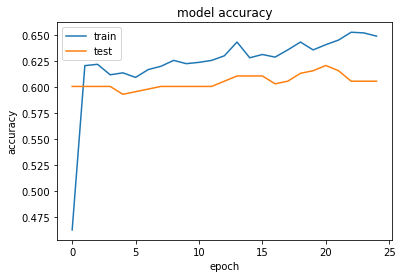

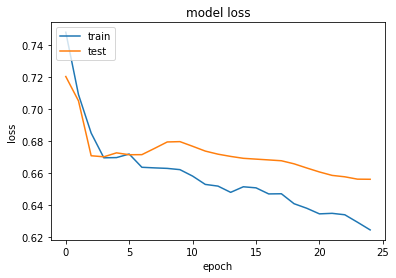

In [99]:
history = model.fit(x_train, y_softmax_train, validation_data=(x_val, y_softmax_val), epochs=25, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('lstm_w2v.h5')

Explanation using LIME

In [101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

In [102]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       398
           1       0.00      0.00      0.00         0

    accuracy                           0.89       398
   macro avg       0.50      0.44      0.47       398
weighted avg       1.00      0.89      0.94       398



/home/patrycja/anaconda3/envs/w2w/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
y_1=np.argmax(model.predict(np.expand_dims(x_val[0],axis=0)))

In [145]:
y_1

0

In [144]:
explainer = lime_tabular.RecurrentTabularExplainer(x_train, training_labels=y_train, feature_names=word_index,
                                                   discretize_continuous=True,
                                                   class_names=['NoToxic', 'Toxic'],
                                                   discretizer='decile')



ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
exp = explainer.explain_instance(X_test[50], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

In [104]:
from lime.lime_text import LimeTextExplainer

In [105]:
explainer = LimeTextExplainer(class_names=["NoToxic","Toxic"])

In [ ]:
data_temp = np.zeros((len(train_df), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(train_df.sentence):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_temp[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [107]:
a =enumerate(train_df.sentence)

In [132]:
new_predict(string).shape

(1992, 2)

In [148]:
def new_predict(x):
    for word in x:
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data[0][k] = tokenizer.word_index[word]
                data.shape
        except:
                #
            pass
    return np.argmax(model.predict(data), axis=1)

In [149]:
new_predict(train_df.iloc[[30]].sentence).shape

(1992,)

In [123]:
a = train_df.iloc[[30]].sentence.to_string

In [126]:
train_df.sentence.iloc[[30]]

30    no federal money is allow to be spent on abort...
Name: sentence, dtype: object

In [127]:
string= "no federal money is allow to be spent on abort..."

In [128]:
idx = 30
exp = explainer.explain_instance(string,new_predict , num_features=6, top_labels=2)

ValueError: Found input variables with inconsistent numbers of samples: [5000, 1992]